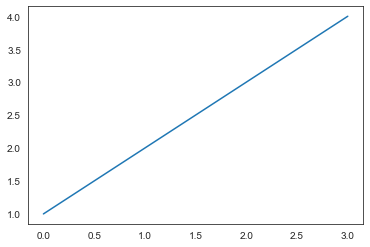

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from pprint import pprint

from collections import defaultdict
from scipy.sparse import csc_matrix
from sympy import nextprime, primefactors
from sympy.ntheory import factorint
import scipy
import networkx as nx
from itertools import combinations_with_replacement
import cvxpy as cp

%matplotlib inline
sns.set_style("white")
plt.plot(np.arange(1,5));

In [2]:
triples = [
    ("A", 'R1', 'B'),
    ("A", 'R2', 'C'),
    ("D", 'R1', 'A'),
    ("B", 'R2', 'E'),
    ('C', 'R3', 'B'),
    ('D', 'R1', 'C'),
    ('D', 'R3', 'B'),
    ("E", "R3", 'D')
]
triples_df = pd.DataFrame.from_records(triples, columns=['head', 'rel', 'tail'])

unique_rels = sorted(triples_df['rel'].unique())
unique_nodes = sorted(set(triples_df['head'].values.tolist() + triples_df['tail'].values.tolist()))
print(f'# of unique rels: {len(unique_rels)} \t | # of unique nodes: {len(unique_nodes)}')

# of unique rels: 3 	 | # of unique nodes: 5


In [3]:
G = nx.from_pandas_edgelist(triples_df, source='head', target='tail', edge_attr='rel', create_using=nx.MultiDiGraph())

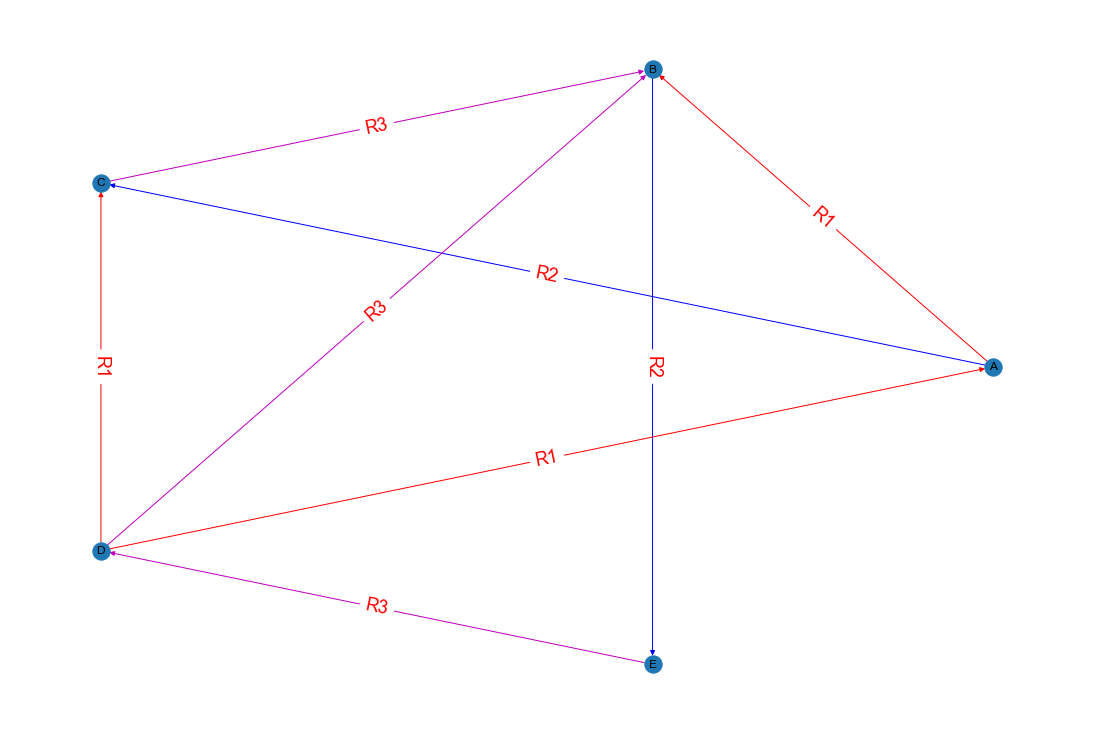

In [4]:
colormap = {
    'R1': 'r',
    'R2': 'b',
    'R3': 'm'
}

pos = nx.circular_layout(G)
edges = G.edges()

colors = []
edge_labels = {}
for (u,v,attrib_dict) in list(G.edges.data()):
    colors.append(colormap[attrib_dict['rel']])
    edge_labels[(u,v)] = attrib_dict['rel']

plt.figure(figsize=(15,10))
nx.draw(G, pos, edge_color=colors, with_labels = True)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,font_color='red', font_size=18)
plt.axis('off')
plt.show()

In [5]:
unique_rels = sorted(triples_df['rel'].unique())
rel2id = {}
id2rel = {}
for i, rel in enumerate(unique_rels):
    rel2id[rel] = i
    id2rel[i] = rel

unique_nodes = sorted(list(G.nodes()))
node2id = {}
id2node = {}
for i, node in enumerate(unique_nodes):
    node2id[node] = i
    id2node[i] = node

In [6]:
from sympy import nextprime, primefactors
relid2prime = {}
prime2relid = {}
current_int = 2
for relid in id2rel.keys():
    cur_prime = nextprime(current_int)
    relid2prime[relid] = cur_prime
    prime2relid[cur_prime] = relid
    current_int = cur_prime
print(relid2prime)




{0: 3, 1: 5, 2: 7}


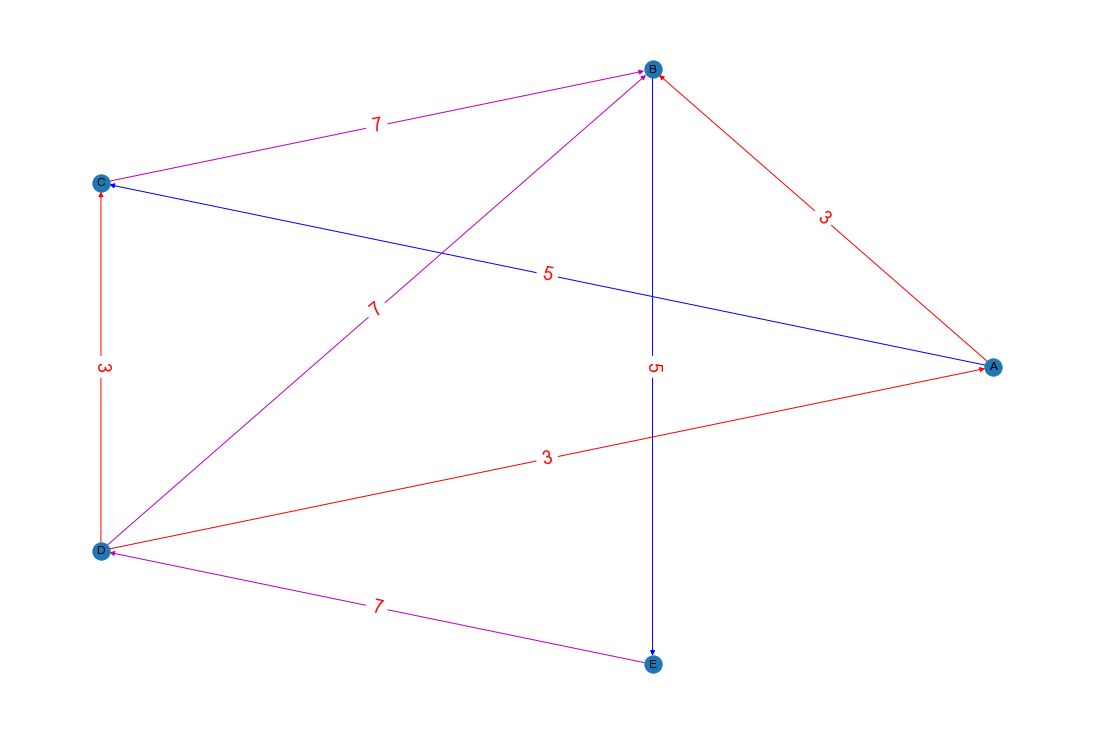

In [7]:
edge_labels2 = {}
for key, value in edge_labels.items():
    edge_labels2[key] = relid2prime[rel2id[value]]

plt.figure(figsize=(15,10))
nx.draw(G, pos, edge_color=colors, with_labels = True)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels2,font_color='red', font_size=18)
plt.axis('off')
plt.show()

In [8]:
A = np.zeros((len(unique_nodes), len(unique_nodes)), dtype=np.int64)
for i, row in triples_df.iterrows():
    A[node2id[row['head']], node2id[row['tail']]] = relid2prime[rel2id[row['rel']]]
A_clipped = A.copy().clip(0, 1)


In [9]:
from pprint import pprint

pprint(np.matmul(A, A)[np.matmul(A, A)>0].prod())

218882287968750


In [10]:
dd = pd.DataFrame(np.matmul(A, A), columns=['A', 'B', 'C', 'D', 'E'])
dd.index = ['A', 'B', 'C', 'D', 'E']
dd

,A,B,C,D,E
A,0,35,0,0,15
B,0,0,0,35,0
C,0,0,0,0,35
D,0,30,15,0,35
E,21,49,21,0,0


In [11]:
def ILP_solver(denominations, target_value, max_number_of_coins):
    """
    Solver using GLPK_MI for boolean integer linear programming
    :param denominations: list, list of avaialble denominations to break the target value into
    :param target_value: int, target value that needs to be broken into a sum of denominations
    :param max_number_of_coins: int, the number of denominations used to create the target value
    :return: dict, {'denomination_1':times_used1, 'denomination2':times_used2, ...}
    """
    w = cp.Constant(denominations,)
    CASH = cp.Constant(target_value)
    max_number_of_coins = cp.Constant(max_number_of_coins)

    x = cp.Variable((1, w.shape[0]), integer=True)

    # We want to minimize the total number of coins returned
    objective = cp.Minimize(cp.abs(max_number_of_coins -cp.sum(x)))
    #print(CASH, max_number_of_coins, w)
    # The constraints
    constraints = [
        w@x.T == CASH,
        #cp.sum(x) == max_number_of_coins, #
        x>=0 # semi-positive coins
    ]
    # Form and solve problem.
    prob = cp.Problem(objective, constraints)
    # Need the GLPK_MI solver because the ECOS_BB is not working correctly.
    prob.solve(solver = 'GLPK_MI') # Returns the optimal value.
    if prob.status == 'infeasible':
        raise ValueError("Infeasible. Can't create %s with %s denominations from: %s"%(CASH.__str__(), max_number_of_coins.__str__(),  w.__str__()))
    else:
        #print("Initial cash %s  is changed into %d coins as follows:"%(CASH.__str__(), prob.value))
        return dict(zip([w_ for w_ in w.value], x.value.flatten()))

In [14]:
def get_paths_connecting(head, tail, adj, adj_num, possible_prime_products, return_representation='primes', return_correct_order=False):
    """
    Helper function that given a specific pairs returns the paths from head->tail
    :param head: int, id of the head in the adjacency
    :param tail: int, id of the tail in the adjacency
    :param possible_prime_products: list, with possible products from the combinations of primes used
    :param return_representaion: str, one of ['primes', 'originals'].
                                - primes: returns the edges with their corresponding prime indexing
                                - original: returns the edges with their original names
    :param return_correct_order: boolean, if True find the correct order of the relations as well
    :return: list, list of paths in the form of tuples [('path_1_hop_1, path_1_hop_2, ...), ...('path_N_hop_1', 'path_N_hop_2)]
    """
    # Simple case where we factorize the product
    if adj[head, tail] == 0:
        return []
    if return_correct_order:
        raise NotImplementedError('Not yet')
    num_paths = adj_num[head, tail]
    wanted_factor_dicts = []
    if num_paths == 1:
        fact_dict = factorint(adj[head, tail])
        wanted_factor_dicts = [fact_dict]
    # Complex case where this is a sum of factorized products
    else:
        wanted_value = adj[head, tail]
        products_dict = ILP_solver([item for item in possible_prime_products if item <= wanted_value], wanted_value, num_paths)
        for product_of_primes, num_of_occurrences in products_dict.items():
            for _ in range(int(num_of_occurrences)):
                wanted_factor_dicts.append(factorint(int(product_of_primes)))
        #for item in combinations_with_replacement(prime2relid.keys(), num_paths)
        #print(wanted_factor_dicts)
        #raise NotImplementedError('Not yet')
    factors = []
    for factor_dict in wanted_factor_dicts:
        cur_factor = []
        for factor, times in factor_dict.items():
            if return_representation == 'originals':
                cur_repr = id2rel[prime2relid[factor]]
            else:
                cur_repr = factor
            cur_factor.extend([cur_repr for _ in range(times)])
        factors.append(cur_factor)
    return factors

In [20]:
pprint(power_A[1])

array([[ 0, 35,  0,  0, 15],
       [ 0,  0,  0, 35,  0],
       [ 0,  0,  0,  0, 35],
       [ 0, 30, 15,  0, 35],
       [21, 49, 21,  0,  0]])


In [19]:


max_order = 5
power_A = [A]
power_A_clipped = [A_clipped]

for _ in range(1,max_order):
    power_A.append(np.matmul(power_A[-1], A))
    power_A_clipped.append(np.matmul(power_A_clipped[-1], A_clipped))
power_A_clipped[3]

array([[1, 1, 1, 1, 0],
       [0, 2, 1, 0, 1],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 2, 1],
       [0, 1, 0, 1, 2]])

In [12]:
head, tail = 3, 2
power_order = 3

#head_prior_relations = power_A[power_order-1][head,:].tolist()
#tail_prior_relations = power_A[power_order-1][:,tail].tolist()
#total_prior_relations = list(set(head_prior_relations + tail_prior_relations))
#possible_prime_products = [np.prod(item) for item in combinations_with_replacement(total_prior_relations, 2)]
possible_prime_products=[np.prod(item) for item in combinations_with_replacement(prime2relid.keys(), power_order + 1)]
get_paths_connecting(head=head,
                     tail=tail,
                     adj=power_A[power_order],
                     adj_num=power_A_clipped[power_order],
                     possible_prime_products=possible_prime_products,
                     return_representation='primes')


[[3, 5, 7, 7]]

In [ ]:
from numpy.testing import assert_array_equal
(scipy.sparse.csr_matrix(power_A[3])!=scipy.sparse.csr_matrix(power_A[2])*scipy.sparse.csr_matrix(power_A[0])).nnz==0

In [ ]:
A_big = np.random.randint(0,3, size=(40000, 40000), dtype=np.int32)

In [ ]:
def vec_translate(a, relid2prime):
    return np.vectorize(relid2prime.__getitem__)(a)

A_big = vec_translate(A_big, relid2prime)
A[0]

In [ ]:
relid2prime

In [19]:
path_to_files = '../data/lc-neo4j-triplets.tsv'
df_train = pd.read_csv(path_to_files, sep='\t', header=None, dtype='str', skiprows=1)
df_train.columns = ['head', 'rel', 'tail']
df_train.head()

,head,rel,tail
0,Proliferation (morphologic abnormality),COEXISTS_WITH,Malignant mesothelioma
1,Inhalation Exposure,COEXISTS_WITH,Malignant mesothelioma
2,cell growth,COEXISTS_WITH,Malignant mesothelioma
3,Sarcoma,COEXISTS_WITH,Malignant mesothelioma
4,Neoplasms,COEXISTS_WITH,Malignant mesothelioma


# Real world scenario

In [2]:
path_to_files = '../data/YAGO3-10-DR/'
project = "YAGO3-10-DR"
df_train = pd.read_csv(path_to_files+"train.txt", sep='\t', header=None, dtype='str')
df_train.columns = ['head', 'rel', 'tail']
# in case no valid.txt being there
try:
    df_eval = pd.read_csv(path_to_files+"valid.txt", sep='\t', header=None, dtype='str')
    df_eval.columns = ['head', 'rel', 'tail']
except FileNotFoundError:
    df_eval = df_train.copy()

df_test = pd.read_csv(path_to_files+"test.txt", sep='\t', header=None, dtype='str')
df_test.columns = ['head', 'rel', 'tail']
for cur_df in [df_train, df_eval, df_test]:
    #cur_df = cur_df.astype(str)
    if "YAGO" in path_to_files:
        for col in cur_df.columns:
            cur_df[col] = cur_df[col] + "_YAGO"

already_seen_triples = set(df_train.to_records(index=False).tolist() + df_eval.to_records(index=False).tolist())
print(f'Total: {len(already_seen_triples)} triples in train + eval!)')
print(f'In train: {len(df_train)}')


Total: 735915 triples in train + eval!)
In train: 732556


In [21]:
str = ""
for rel_i, _ in enumerate(unique_rels):
    str += f"rel_{rel_i}/2\n"
i_max = 100
for i, row in df_train.iterrows():
    str += f"rel_{unique_rels.index(row['rel'])}('{unique_nodes.index(row['head'])}', '{unique_nodes.index(row['tail'])}').\n"
    if i == i_max:
        break
print(str[:100])

rel_0/2
rel_1/2
rel_0('0', '2').
rel_1('2', '3').
rel_1('2', '1').



In [19]:
triples = [
    ("Kostas", "KNOWS", "Nikos"),
     ("Nikos", "LOVES", "Takis"),
      ("Nikos", "LOVES", "Me")
]
df_train = pd.DataFrame(triples)
df_train.columns = ['head', 'rel', 'tail']

In [22]:
with open("../data/YAGO3-10-DR/train_prolog.pl", 'w+') as f:
    f.write(str)

In [20]:
unique_rels = sorted(list(df_train['rel'].unique()))
unique_nodes = sorted(set(df_train['head'].values.tolist() + df_train['tail'].values.tolist()))
print(f'# of unique rels: {len(unique_rels)} \t | # of unique nodes: {len(unique_nodes)}')

# of unique rels: 2 	 | # of unique nodes: 4


In [27]:
rel2id = {}
id2rel = {}
for i, rel in enumerate(unique_rels):
    rel2id[rel] = i
    id2rel[i] = rel

node2id = {}
id2node = {}
for i, node in enumerate(unique_nodes):
    node2id[node] = i
    id2node[i] = node

from sympy import nextprime, primefactors
relid2prime = {}
prime2relid = {}
current_int = 2
for relid in id2rel.keys():
    cur_prime = nextprime(current_int)
    relid2prime[relid] = cur_prime
    prime2relid[cur_prime] = relid
    current_int = cur_prime
print(relid2prime)


{0: 3, 1: 5, 2: 7, 3: 11, 4: 13, 5: 17, 6: 19, 7: 23, 8: 29, 9: 31, 10: 37, 11: 41, 12: 43, 13: 47, 14: 53, 15: 59, 16: 61, 17: 67, 18: 71, 19: 73, 20: 79, 21: 83, 22: 89, 23: 97, 24: 101, 25: 103, 26: 107, 27: 109, 28: 113, 29: 127, 30: 131, 31: 137, 32: 139, 33: 149, 34: 151, 35: 157}


In [28]:
#A_big = np.zeros((len(unique_nodes), len(unique_nodes)), dtype=np.int16)
#A_ind = A_big.copy()
from collections import defaultdict
from scipy.sparse import csc_matrix
from sympy import nextprime, primefactors

val_rels_dict = defaultdict(int)
num_rels_dict = defaultdict(int)
c = 0
missed_nodes = []
skipped_edge_indexes = []
for i, row in df_train.iterrows():
    if val_rels_dict[(node2id[row['head']], node2id[row['tail']])] > 0:
        c += 1
        missed_nodes.extend([node2id[row['head']], node2id[row['tail']]])
        skipped_edge_indexes.append(i)
        continue
    val_rels_dict[(node2id[row['head']], node2id[row['tail']])] += relid2prime[rel2id[row['rel']]]
    num_rels_dict[(node2id[row['head']], node2id[row['tail']])] += 1
print(f'Skipped {c} edges coming from head to the same tail more than one..')
print(f'Avoid using nodes: {sorted(set(missed_nodes))}')
row = []
col = []
val_rels = []
num_rels = []
for key, val in val_rels_dict.items():
    row.append(key[0])
    col.append(key[1])
    # if val == 1:
    #     cur_val = 0
    # else:
    #     cur_val = val
    val_rels.append(val)
    num_rels.append(num_rels_dict[key])
row = np.array(row)
col = np.array(col)
val_rels = np.array(val_rels)
num_rels = np.array(num_rels)
print('Will create the sparse matrices')

A_big = csc_matrix((val_rels, (row, col)), shape=(len(unique_nodes), len(unique_nodes)), dtype=np.int64)
A_num_rels = csc_matrix((num_rels, (row, col)), shape=(len(unique_nodes), len(unique_nodes)), dtype=np.int64)

Skipped 7357 edges coming from head to the same tail more than one..
Avoid using nodes: [0, 30, 65, 74, 145, 169, 172, 220, 244, 326, 332, 349, 350, 370, 381, 382, 384, 386, 387, 392, 394, 395, 400, 407, 418, 419, 444, 447, 449, 458, 467, 492, 501, 505, 508, 513, 516, 519, 534, 535, 602, 615, 618, 658, 659, 669, 678, 685, 686, 690, 693, 716, 718, 727, 729, 740, 746, 777, 783, 789, 791, 844, 857, 877, 920, 931, 939, 970, 986, 1027, 1043, 1063, 1078, 1094, 1102, 1117, 1123, 1168, 1182, 1197, 1200, 1207, 1246, 1250, 1254, 1255, 1260, 1262, 1267, 1275, 1276, 1293, 1310, 1362, 1369, 1378, 1380, 1413, 1417, 1437, 1440, 1444, 1445, 1474, 1480, 1485, 1498, 1500, 1511, 1512, 1513, 1514, 1516, 1518, 1519, 1520, 1522, 1525, 1527, 1528, 1533, 1535, 1537, 1538, 1539, 1540, 1541, 1542, 1544, 1560, 1561, 1575, 1576, 1608, 1611, 1613, 1631, 1633, 1642, 1643, 1651, 1664, 1667, 1683, 1698, 1702, 1719, 1733, 1741, 1753, 1757, 1802, 1813, 1869, 1876, 1877, 1922, 1923, 1944, 1984, 2001, 2007, 2011, 2012, 2

In [29]:
len(df_train)

732556

In [30]:
import time
max_order = 3

power_A = [A_big]#[A, np.matmul(A, A), np.matmul(np.matmul(A, A), A)]
power_A_clipped = [A_num_rels]
time_s = time.time()
time_prev = time_s
for ii in range(1, max_order):
    power_A.append(power_A[-1] * A_big)
    #power_A_clipped.append(power_A_clipped[-1] * A_num_rels)
    time_prev = time.time()
    time_needed = time_prev - time_s
    print(f'{ii}: {time_needed:.5f} secs ({time_needed/60:.2f} mins)')
time_prev = time.time()
time_needed = time_prev - time_s
print(f'{ii}: {time_needed:.5f} secs ({time_needed/60:.2f} mins)')
len(power_A)

1: 0.06811 secs (0.00 mins)
2: 0.55865 secs (0.01 mins)
2: 0.55890 secs (0.01 mins)


3

In [ ]:
power_A[1][14,3]

In [ ]:
power_A[0][14,:].toarray().flatten().dot(power_A[0][:,3].toarray().flatten())

In [ ]:
power_A_clipped

In [ ]:
prime2relid

In [ ]:

head, tail = , 1
power_order = 1

#head_prior_relations = power_A[power_order-1][head,:].tolist()
#tail_prior_relations = power_A[power_order-1][:,tail].tolist()
#total_prior_relations = list(set(head_prior_relations + tail_prior_relations))
#possible_prime_products = [np.prod(item) for item in combinations_with_replacement(total_prior_relations, 2)]
possible_prime_products=[np.prod(item) for item in combinations_with_replacement(prime2relid.keys(), power_order + 1)]
get_paths_connecting(head=head,
                     tail=tail,
                     adj=power_A[power_order],
                     adj_num=power_A_clipped[power_order],
                     possible_prime_products=possible_prime_products,
                     return_representation='primes')

# Cross-check results with networkx



In [19]:
import tqdm
from collections import defaultdict
def get_filtering_cache(df_train, df_eval, df_test):
    cache_triples = defaultdict(list)
    all_triples = df_train
    for triple in tqdm.tqdm_notebook(all_triples.to_records()):
        # Adding h,r ->t
        cache_triples[(triple[1], triple[2])].append(triple[3])
        # Addubg r, t -> h
        cache_triples[(triple[2], triple[3])].append(triple[1])
    return cache_triples

cache_triples = get_filtering_cache(df_train, df_eval, df_test)


/Users/Konstantinos.Bougiatiotis@ey.com/anaconda3/envs/lola/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/86835 [00:00<?, ?it/s]

In [20]:
def get_egograph(whole_df, root, radius=2, keep_direction=True):
    """
    Simple function to generate a (un)directed ego-graph of N-hops from a starting node
    given a KG.
    Input:
    - whole_df: pd.DataFrame,
      KG in a dataframe with columns [head, rel, tail]
    - root: str,
      the label of the root node
    - radius: int,
      the size of the neighborhood around the root node to fetch
    - keep_direction: boolean,
      whether to take directionality into account.
    """
    steps = radius
    seeds = [root]
    subgraph = ()

    while steps > 0:
        if keep_direction:
            cur_subgraph = whole_df[whole_df['head'].isin(seeds)]
            seeds = cur_subgraph['tail'].unique().tolist()
        else:
            cur_subgraph_head = whole_df[whole_df['head'].isin(seeds)]
            seed_head = cur_subgraph_head['tail'].unique().tolist()
            cur_subgraph_tail = whole_df[whole_df['tail'].isin(seeds)]
            seed_tail = cur_subgraph_tail['head'].unique().tolist()
            cur_subgraph = pd.concat((cur_subgraph_head, cur_subgraph_tail), axis=0)
            seeds = list(set(seed_tail + seed_head))
        #if steps == 1:
        if len(subgraph) == 0:
            subgraph = cur_subgraph
        else:
            subgraph = pd.concat((subgraph, cur_subgraph), axis=0)
        steps -= 1
    #subgraph.drop_duplicates(inplace=True)
    return subgraph.values.tolist()

sum([1 for triple in get_egograph(df_train, id2node[4774], radius=4) if triple[2] == id2node[104]])

12

In [ ]:
c = 0
for hop1_tail in cache_triples[(id2node[4774], '_derivationally_related_form')]:
    hop_2_tails = cache_triples[(hop1_tail, '_derivationally_related_form')]
    if id2node[104] in hop_2_tails:
        c += 1
print(c)


In [21]:
import networkx as nx
mg = nx.MultiDiGraph()
edges = []
for i, row in df_train.iterrows():
    if i in skipped_edge_indexes:
        continue
    edges.append((row['head'], row['tail'], str(row['rel'])))
    #break
mg.add_edges_from(edges);


In [32]:
mg.edges()

OutMultiEdgeDataView([('00260881', '00260622'), ('00260881', '01124794'), ('00260622', '00265386'), ('00260622', '00248977'), ('00260622', '00265673'), ('01332730', '03122748'), ('01332730', '02840619'), ('01332730', '01336635'), ('01332730', '01207951'), ('01332730', '04151940'), ('03122748', '01332730'), ('03122748', '00021939'), ('06066555', '00645415'), ('06066555', '09868270'), ('06066555', '06037666'), ('00645415', '06066555'), ('00645415', '00643473'), ('09322930', '09360122'), ('09360122', '08617963'), ('07193596', '00784342'), ('07193596', '00788184'), ('07193596', '07193184'), ('07193596', '00808855'), ('07193596', '00785008'), ('00784342', '10207831'), ('00784342', '00740577'), ('00784342', '07193596'), ('00784342', '00897746'), ('00784342', '07193184'), ('00784342', '00784727'), ('01768969', '02636811'), ('01768969', '08103777'), ('01768969', '01775879'), ('01768969', '01771966'), ('01768969', '01769347'), ('01768969', '01770553'), ('01768969', '01769635'), ('02636811', '01

In [23]:
head, tail = 4774, 104
cur_paths = []
print(f'Paths between 4774 ,104:')
c = 0
max_hops = 4
for path in sorted(nx.all_simple_edge_paths(mg, id2node[head],id2node[tail], cutoff=max_hops)):
    cur_paths.append(" -- ".join([hop[-1] for hop in path]))
    if len(path) == max_hops:
        print(cur_paths[-1])
        c +=1
print(f' Paths: {c}')

Paths between 4774 ,104:
_also_see -- _derivationally_related_form -- _derivationally_related_form -- _hypernym
_derivationally_related_form -- _derivationally_related_form -- _derivationally_related_form -- _derivationally_related_form
_derivationally_related_form -- _derivationally_related_form -- _derivationally_related_form -- _derivationally_related_form
 Paths: 3


In [27]:
power_order = 3
head_prior_relations = power_A[0][head,:].toarray().flatten().tolist()
tail_prior_relations = power_A[0][:,tail].toarray().flatten().tolist()
total_prior_relations = list(set(head_prior_relations + tail_prior_relations))
possible_prime_products = [np.prod(item) for item in combinations_with_replacement(total_prior_relations, power_order + 1)]
#possible_prime_products=[np.prod(item) for item in combinations_with_replacement(prime2relid.keys(), power_order + 1)]
paths_tensor = get_paths_connecting(head=head,
                     tail=tail,
                     adj=power_A[power_order],
                     adj_num=power_A_clipped[power_order],
                     possible_prime_products=possible_prime_products,
                     return_representation='originals')
print(f'Paths: {len(paths_tensor)}')
paths_tensor

Paths: 8


[['_hypernym', '_hypernym', '_hypernym', '_hypernym'],
 ['_also_see', '_also_see', '_also_see', '_hypernym'],
 ['_also_see', '_also_see', '_also_see', '_hypernym'],
 ['_also_see', '_also_see', '_derivationally_related_form', '_hypernym'],
 ['_also_see', '_also_see', '_derivationally_related_form', '_hypernym'],
 ['_also_see',
  '_derivationally_related_form',
  '_derivationally_related_form',
  '_hypernym'],
 ['_also_see',
  '_derivationally_related_form',
  '_derivationally_related_form',
  '_derivationally_related_form'],
 ['_also_see',
  '_derivationally_related_form',
  '_derivationally_related_form',
  '_derivationally_related_form']]

In [28]:
power_A_clipped[power_order][4774,104]

32

In [ ]:
print(power_A_clipped[2][12, 10], id2node[12], id2node[10])
[triple for triple in get_egograph(df_train, id2node[12], radius=3)]

In [ ]:
for hop1_tail in cache_triples[(id2node[12], '_derivationally_related_form')]:
    print(hop1_tail)
    #hop_2_tails = cache_triples[(hop1_tail, '_derivationally_related_form')]

In [ ]:

radius = 3
subgraph_triples = get_egograph(df_train, id2node[head_id], radius=radius)
paths = []
for hop1_triple in subgraph_triples:
    if hop1_triple[0] == head_id:
        nodes = [head_id]
        rels = []
        for hop2_triple in triples:
            if hop2_triple[0] == hop1_triple[2]:
                rels.append(hop2_triple[1])
                nodes.append(hop2_triple[2])




In [ ]:
radius = 1
power_order = radius - 1
possible_prime_products=[np.prod(item) for item in combinations_with_replacement(prime2relid.keys(), power_order + 1)]
for head_id in tqdm.tqdm_notebook(range(len(node2id)), total=len(node2id)):
    if head_id in missed_nodes:
        continue
    for tail_id in [head_id]:
        if tail_id in missed_nodes:
            continue
        c_df = sum([1 for triple in get_egograph(df_train, id2node[head_id], radius=radius) if triple[2] == id2node[tail_id]])
        paths_tensor = get_paths_connecting(head=head_id,
                     tail=tail_id,
                     adj=power_A[power_order],
                     adj_num=power_A_clipped[power_order],
                     possible_prime_products=possible_prime_products,
                     return_representation='originals')
        c_tensor = len(paths_tensor)
        if c_df != c_tensor:
            print(f'[ {head_id, tail_id} ]  differences: DF {c_df} vs T {c_tensor}')

In [ ]:
head_id, tail_id = 19, 46
radius = 3
max_hops = radius
cur_paths = []
print(f'Paths between {head_id} ({id2node[head_id]}), {tail_id} ({id2node[tail_id]} ):')
c = 0

for path in sorted(nx.all_simple_edge_paths(mg, id2node[head_id],id2node[tail_id], cutoff=max_hops)):
    cur_paths.append(" -- ".join([hop[-1] for hop in path]))
    if len(path) == max_hops:
        print(cur_paths[-1])
        c +=1
print(f' Paths: {c}')


In [ ]:
power_A_clipped[2][19,46]

In [ ]:
(relid2prime[rel2id['_derivationally_related_form']]**4)*8

In [ ]:
print(power_A_clipped[2][19,46])
print((power_A_clipped[1] * power_A_clipped[0])[19,46])
(power_A_clipped[1][19,:] * power_A_clipped[0][:,46]).data[0]

In [ ]:
print(power_A_clipped[1][19,:].data, power_A_clipped[1][19,:].nonzero()[1].tolist(),)
print(power_A_clipped[0][:,46].data, power_A_clipped[0][:,46].nonzero()[0].tolist(),)

In [ ]:
print(power_A_clipped[1][19,19])
print(power_A_clipped[0][19,:].data, power_A_clipped[0][19,:].nonzero()[1].tolist(),)
print(power_A_clipped[0][:,19].data, power_A_clipped[0][:,19].nonzero()[0].tolist(),)

In [ ]:
[node2id[n_] for n_ in cache_triples[(id2rel[prime2relid[5]], id2node[19])]]

In [ ]:
power_A_clipped[1][19,19]

In [ ]:
head_id, tail_id = 19, 19
radius = 4
max_hops = radius
cur_paths = []
print(f'Paths between {head_id} ({id2node[head_id]}), {tail_id} ({id2node[tail_id]} ):')
c = 0

for path in sorted(nx.all_simple_edge_paths(mg, id2node[head_id],id2node[tail_id], cutoff=max_hops)):
    cur_paths.append(" -- ".join([hop[-1] for hop in path]))
    if len(path) == max_hops:
        print(cur_paths[-1])
        c +=1
print(f' Paths: {c}')

In [ ]:
head, tail = 19, 46
power_order = 2

head_prior_relations = power_A[0][head,:].toarray().flatten().tolist()
tail_prior_relations = power_A[0][:,tail].toarray().flatten().tolist()
total_prior_relations = list(set(head_prior_relations + tail_prior_relations))
#possible_prime_products = [np.prod(item) for item in combinations_with_replacement(total_prior_relations, power_order + 1)]
possible_prime_products=[np.prod(item) for item in combinations_with_replacement(prime2relid.keys(), power_order + 1)]
paths_tensor = get_paths_connecting(head=head,
                     tail=tail,
                     adj=power_A[power_order],
                     adj_num=power_A_clipped[power_order],
                     possible_prime_products=possible_prime_products,
                     return_representation='originals')
print(f'Paths: {len(paths_tensor)}')
paths_tensor

In [ ]:
def ILP_solver(denominations, target_value, max_number_of_coins):
    """
    Solver using GLPK_MI for boolean integer linear programming
    :param denominations: list, list of avaialble denominations to break the target value into
    :param target_value: int, target value that needs to be broken into a sum of denominations
    :param max_number_of_coins: int, the number of denominations used to create the target value
    :return: dict, {'denomination_1':times_used1, 'denomination2':times_used2, ...}
    """
    w = cp.Constant(denominations,)
    CASH = cp.Constant(target_value)
    max_number_of_coins = cp.Constant(max_number_of_coins)

    x = cp.Variable((1, w.shape[0]), integer=True)

    # We want to minimize the total number of coins returned
    objective = cp.Minimize(cp.abs(max_number_of_coins - cp.sum(x)))
    #print(CASH, max_number_of_coins, w)
    # The constraints
    constraints = [
        w@x.T == CASH,
        cp.sum(x) == max_number_of_coins, #
        x>=0 # semi-positive coins
    ]
    # Form and solve problem.
    prob = cp.Problem(objective, constraints)
    # Need the GLPK_MI solver because the ECOS_BB is not working correctly.
    prob.solve(solver = 'GLPK_MI') # Returns the optimal value.
    if prob.status == 'infeasible':
        raise ValueError("Infeasible. Can't create %s with %s denominations from: %s"%(CASH.__str__(), max_number_of_coins.__str__(),  w.__str__()))
    else:
        #print("Initial cash %s  is changed into %d coins as follows:"%(CASH.__str__(), prob.value))
        return dict(zip([w_ for w_ in w.value], x.value.flatten()))

def get_paths_connecting(head, tail, adj, adj_num, possible_prime_products, return_representation='primes', return_correct_order=False):
    """
    Helper function that given a specific pairs returns the paths from head->tail
    :param head: int, id of the head in the adjacency
    :param tail: int, id of the tail in the adjacency
    :param possible_prime_products: list, with possible products from the combinations of primes used
    :param return_representaion: str, one of ['primes', 'originals'].
                                - primes: returns the edges with their corresponding prime indexing
                                - original: returns the edges with their original names
    :param return_correct_order: boolean, if True find the correct order of the relations as well
    :return: list, list of paths in the form of tuples [('path_1_hop_1, path_1_hop_2, ...), ...('path_N_hop_1', 'path_N_hop_2)]
    """
    # Simple case where we factorize the product
    if adj[head, tail] == 0:
        return []
    if return_correct_order:
        raise NotImplementedError('Not yet')
    num_paths = adj_num[head, tail]
    wanted_factor_dicts = []
    if num_paths == 1:
        fact_dict = factorint(adj[head, tail])
        wanted_factor_dicts = [fact_dict]
    # Complex case where this is a sum of factorized products
    else:
        wanted_value = adj[head, tail]
        print(f'WV{wanted_value}, NM{num_paths}')
        products_dict = ILP_solver([item for item in possible_prime_products if item <= wanted_value], wanted_value, num_paths)
        approx = 0
        for product_of_primes, num_of_occurrences in products_dict.items():
            for _ in range(int(num_of_occurrences)):
                approx += product_of_primes
                wanted_factor_dicts.append(factorint(int(product_of_primes)))
                if num_of_occurrences > 0:
                    print(product_of_primes, num_of_occurrences)
        print(approx, wanted_value)
        #raise NotImplementedError('Not yet')
    factors = []
    for factor_dict in wanted_factor_dicts:
        cur_factor = []
        for factor, times in factor_dict.items():
            if return_representation == 'originals':
                cur_repr = id2rel[prime2relid[factor]]
            else:
                cur_repr = factor
            cur_factor.extend([cur_repr for _ in range(times)])
        factors.append(cur_factor)
    return factors

In [ ]:

power_A_clipped[3][4774,104]

In [ ]:
power_A_clipped[2][4774, 104]

In [ ]:
s = 0
for index_non_zero, val in enumerate(power_A[2][4774,:].nonzero()[1]):
    cur_s = 0
    cur_s = power_A[2][4774,val] * power_A[0][val,104]
    if cur_s != 0:
        print(cur_s)
        print(f'Common element: {val}  PA_2[4774:{val}] = {power_A[2][4774,val]} PA_0[{val},:] = {power_A[0][val,104]}| Adding: {cur_s}')
        print(f'{s} + {cur_s} = {s + cur_s}')
    s += cur_s

In [ ]:
(power_A[2][4774,:] * power_A[0][:,104])[0,0], power_A[3][4774, 104]

In [ ]:
(power_A[2][4774,:] * power_A[0][:,104])[0,0]

In [ ]:
power_A[3][4774,104]

In [ ]:
ss = 0
for path in cur_paths:
    cur_hops = path.split(" -- ")
    if len(cur_hops) == 4:
        cur_ss = 1
        print(path)
        for hop in cur_hops:
            cur_ss *= relid2prime[rel2id[hop]]
        print(f'Adding: {cur_ss}')
        ss += cur_ss
print(ss, power_A[3][4774,104])

In [ ]:
pprint(power_A[2][4774,[   87,   137,   533,   714,  1020,  1053,  2496,  3126,  4400,
         4417,  4774,  5752, 12945, 13138, 16198, 18963, 19515, 19518,
        19522, 19925, 20345, 20358, 21700, 30361, 32924, 38690]].toarray().tolist())

In [ ]:
scipy.sparse.find(power_A[2][4774,:] == 12117361)

In [ ]:
s = 0
for index_non_zero, val in enumerate(power_A_clipped[2][4774,:].nonzero()[1]):
    cur_s = 0
    cur_s = power_A_clipped[2][4774,val] * power_A_clipped[0][val,104]
    if cur_s != 0:
        print(cur_s)
        #print(f'Common element: {val}  PA_2[4774:{val}] = {power_A_clipped[2][4774,val]} PA_0[{val},104] = {power_A_clipped[0][val,104]}| Adding: {cur_s}')

        print(f'{s} + {cur_s} = {s + cur_s}')
    s += cur_s
print(s)

In [ ]:
power

In [ ]:
%timeit A_big.multiply(A_big)

In [ ]:
A_2 = A_big.multiply(A_big)
A_2_num_rels =A_num_rels.multiply(A_num_rels)

In [ ]:
A_3 = A_2.multiply(A_big)

In [ ]:
A_2[0].nonzero()

In [ ]:
factorint(A_2[0,3])

In [ ]:
A_2[0,3]

In [ ]:
primefactors(1369)


In [ ]:
index = 100
rows, cols, _ = scipy.sparse.find(power_A_clipped[1] > 1)
rows[index], cols[index], power_A_clipped[1][rows[index], cols[index]], power_A[1][rows[index], cols[index]]

In [ ]:
print(rows[5], cols[30])
power_A_clipped[0][14,:].toarray().flatten() * (power_A_clipped[0][:,3].toarray().flatten())

In [ ]:
power_A[0][0,3], power_A[0][14,0], power_A[1][14,3]


In [ ]:
factors = []
for key, value in factorint(A_big[rows[0], cols[0]]).items():
    factors.extend([key for i in range(value)])
print(f'Original relations of {A_big[rows[0], cols[0]]}, {factors}')
fixed_sum = np.sum([A_2[rows[0], cols[0]] / factor for factor in factors])
print(f'2-hop Original: {A_2[rows[0], cols[0]]} | fixed sum: {fixed_sum}')


In [ ]:
from itertools import combinations
for comb in combinations(relid2prime.values(), 2):
    print(f'{comb}: {np.sum(comb)}')


In [ ]:
for comb in combinations_with_replacement(relid2prime.values(), 2):
    print(f'{comb}: {np.prod(comb)}')

In [ ]:
A_num_rels[rows[0], cols[0]], A_2_num_rels[rows[0], cols[0]]


In [ ]:
import cvxpy as cp
# The available prime numbers
primes_used = sorted(list(relid2prime.values()))
primes_array = cp.Constant(primes_used)
# The sum of paths
sum_of_paths = cp.Constant(A_big[rows[0], cols[0]])
# The sum of number of paths
sum_of_number_of_paths = cp.Constant(A_2_num_rels[rows[0], cols[0]])
# The factors for this sum
factors_cp = cp.Constant(factors)
# The variable of size Factors X Primes
x = cp.Variable((len(factors), primes_array.shape[0]), boolean=True)

In [ ]:
print(factors_cp.shape[0], primes_array.shape[0])
x.shape

In [ ]:
# We want to minimize the total number of coins returned
objective = cp.Minimize(cp.abs(factors_cp.T@(x@primes_array) - sum_of_paths))



# The constraints
constraints = [
    #factors_cp.T@(x@primes_array) == sum_of_paths,
    cp.sum(x)==sum_of_number_of_paths,
    #w@x.T == CASH, #
    x>=0 # semi-positive coins
]
# Form and solve problem.
prob = cp.Problem(objective, constraints)
# Need the GLPK_MI solver because the ECOS_BB is not working correctly.
prob.solve(solver = 'GLPK_MI') # Returns the optimal value.
if prob.status == 'infeasible':
    print("Can't change %s with denominations: %s"%(CASH.__str__(), w.__str__()))
else:
    print("Initial cash %s  is changed into %d coins as follows:"%(CASH.__str__(), prob.value))
    sum_ = 0
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x.value[i,j] != 0:
                sum_ += factors[i]*primes_used[j]*x.value[i,j]
    print(sum_)
    #for x.value.fla
    #print(dict(zip([w_ for w_ in w.value], x.value.flatten())))

In [ ]:
x.value

In [ ]:



import cvxpy as cp
# The available coin denominations e.g. a 2-dollar bill, a 5-dollar bill and a 10-dollar bill.
w = cp.Constant([2,5,10])

# The initial cash to be changed
CASH = cp.Constant(2)

# Variables containing the number of the coins to be returned for each denominator
# The size of this must be equal to the denominatios w
x = cp.Variable((1, w.shape[0]), integer=True)

# We want to minimize the total number of coins returned
objective = cp.Minimize(cp.sum(x))



# The constraints
constraints = [
    w@x.T == CASH, #
    x>=0 # semi-positive coins
]
# Form and solve problem.
prob = cp.Problem(objective, constraints)
# Need the GLPK_MI solver because the ECOS_BB is not working correctly.
prob.solve(solver = 'GLPK_MI') # Returns the optimal value.
if prob.status == 'infeasible':
    print("Can't change %s with denominations: %s"%(CASH.__str__(), w.__str__()))
else:
    print("Initial cash %s  is changed into %d coins as follows:"%(CASH.__str__(), prob.value))
    print(dict(zip([w_ for w_ in w.value], x.value.flatten())))

In [30]:

for item in nx.algorithms.components.(mg):
    print(item)

{'00455599'}
{'05721180'}
{'01866535', '00644372'}
{'02376958'}
{'02604760'}
{'00404403'}
{'08252602'}
{'01232298'}
{'02465929'}
{'11419404'}
{'05638987'}
{'06115476'}
{'15180528'}
{'00588888'}
{'03348454'}
{'00886281'}
{'01567133'}
{'02681518'}
{'14786479'}
{'06156968'}
{'08566028'}
{'08208016'}
{'06472025'}
{'01631534'}
{'00618451'}
{'04285146'}
{'02371811'}
{'00595935'}
{'05585205'}
{'06284225'}
{'00351485'}
{'04847991'}
{'06764623'}
{'00284930'}
{'05497363'}
{'02434976'}
{'00609953'}
{'04756025'}
{'04776699'}
{'07301336'}
{'00336718'}
{'03024518'}
{'02714315'}
{'04716864'}
{'05510173'}
{'05417975'}
{'05233420'}
{'06264176'}
{'02655135'}
{'00981830'}
{'00010435', '01721556'}
{'13282161'}
{'01679980'}
{'02468617'}
{'02708420'}
{'06709533'}
{'02703952'}
{'03738241'}
{'02690708'}
{'04751098'}
{'05459953'}
{'00514396'}
{'10215623'}
{'04381994'}
{'06874185'}
{'00903449'}
{'00989201', '07241837'}
{'07531255'}
{'01777210'}
{'06346461'}
{'05515670'}
{'00927578', '13959931'}
{'14334122'}
{'0